# First Model for New Data

August 22, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))
print('L4 cells:', len(L4_idx))

LGN cells: 214
V1 cells: 1491
L4 cells: 794


In [4]:
V1_cell_key = [cell_key[i] for i in V1_idx]
L23_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L2/3']
L23_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L2/3']
L4_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L4']

## Data Class

In [4]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L4_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 50.6352744102478 sec


In [5]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60


In [6]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 794


In [7]:
NT = data.NT
print('Number of time points', NT)

Number of time points 510000


In [8]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[L4_idx], y_pos[L4_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (794, 2)


In [9]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=3,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

In [ ]:
adam_pars

## STA

In [ ]:
robs = data[:]['robs']*data[:]['dfs']
nspks = torch.sum(robs,axis=0)

In [ ]:
sta_arr = np.zeros((num_lags,L,L,NC))
for j in range(num_lags):
    if j == 0:
        sta = (data[:]['stim'].T @ robs)
    else:
        sta = (data[:]['stim'][:-j, ...].T @ robs[j:,:])
    sta_arr[j,:,:,:] = (sta/nspks).reshape([L,L,NC]).detach().cpu().numpy()

In [ ]:
sta_arr.shape

In [ ]:
cc = 10
ss(cc,12)
k = 1
for i in range(cc):
    for j in range(12):
        plt.subplot(cc,12,k)
        imagesc(sta_arr[j,:,:,i])
        plt.scatter(pxl_x_pos[i], pxl_y_pos[i], c='r', s=40, marker='+')
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

In [ ]:
# add time series to know tempral lag

In [ ]:
cc = 10
ss(cc,2)
k = 1
for i in range(cc):
    x = int(pxl_x_pos[i])
    y = int(pxl_y_pos[i])
    plt.subplot(cc,2,k)
    imagesc(sta_arr[2,:,:,i])
    plt.scatter(x, y, c='r', s=40, marker='+')
    plt.title('cell '+str(i)+' lag '+str(2))
    k += 1
    plt.subplot(cc,2,k)
    plt.plot([0,num_lags-1],[0,0], 'k')
    plt.plot(sta_arr[:,x,y,i])
    k += 1
plt.tight_layout()
plt.show()

## GLM

In [ ]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=NC, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

glm = NDN( layer_list=[glm_par], loss_type='poisson')
glm.list_parameters()

In [ ]:
glm = glm.to(device)
fit_lbfgs(glm, data[:], verbose=True)
glm = glm.to(device0)

In [ ]:
w_glm = glm.get_weights()
print(w_glm.shape)

In [ ]:
ss(5,12)
k = 1
for i in range(5):
    for j in range(12):
        plt.subplot(5,12,k)
        imagesc(w_glm[:,:,j,i])
        plt.scatter(pxl_x_pos[V1_idx][i],pxl_x_pos[V1_idx][i],c='r',s=40,marker='+')
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

## CNN

In [ ]:
Mreg = 0.1 # max

# LGN layer reg
Xreg0 = 1.0 # d2/dx
Creg0 = 1.0 # center
Treg = 1
#LGNwidth = LGN_filt.shape[0]

# Proj layer — still playing around with these
Xreg1 = 2.0 # d2/dx
Creg1 = 0.1 # center

ORIreg = 0 # chose orientation over spacial dim

# Define convolutional layers in the deep network
num_subs = [20] # num sub-units per layer
fws = [19]  # filter widths for each layer 
angles = [0,30,60,90,120,150] # [0,45,90,135]

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,num_lags], NLtype='lin', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100} )]

# Projection Layer
clayers.append(OriConvLayer.layer_dict(
    num_filters=num_subs[0], num_inh=num_subs[0]//4,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_width=fws[0], NLtype='relu', reg_vals={'d2x':Xreg1, 'center': Creg1},
    angles=angles))

# Rest
#for ii in range(1,len(fws)):
#    clayers.append(OriConvLayer.layer_dict( 
#        num_filters=num_subs[ii], num_inh=num_subs[ii]//4, bias=False, norm_type=1, 
#        filter_width=fws[ii], NLtype='relu',
#        output_norm='batch', initialize_center=True, #window='hamming', 
#        angles=angles) )
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayers, scaffold_levels=[1], num_lags_out=len(angles))

readout_pars = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'gmax_t': ORIreg})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

#cnn.networks[0].layers[0].weight.data = LGN_filt.reshape((LGNwidth**2,2))  # this it the LGN from before
#cnn.networks[0].layers[0].set_parameters(val=True)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)
cnn.block_sample = True
cnn.networks[1].list_parameters()

In [ ]:
#cnn = cnn.to(device)
cnn.fit(data, **adam_pars, verbose=2)
#cnn = cnn.to(device0)

In [ ]:
cnn.save_model_zip('models/0913_four_layer_model.ndn')

In [ ]:
cnn = NDN.load_model_zip('models/0913_four_layer_model.ndn')
cnn.block_sample = True

In [ ]:
cnn.list_parameters()

In [ ]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

In [ ]:
print('Median LL:', np.median(LL))
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.xlim([0,NC])
plt.show()

In [ ]:
cnn.plot_filters()

In [ ]:
ori_filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask = deepcopy(cnn.networks[0].layers[1]._ei_mask)
print(ori_filters1.shape)
print(ei_mask.shape)

In [ ]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters1[0,:,:,i])
plt.tight_layout()
plt.show()

In [ ]:
ori_filters2 = cnn.get_weights(ffnet_target=0,layer_target=2)
print(ori_filters2.shape)

In [ ]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters2[0,:,:,i])
plt.tight_layout()
plt.show()

In [ ]:
sigma = deepcopy(cnn.networks[1].layers[0].sigma.data).numpy()

In [ ]:
ss()
plt.plot(sigma)

In [ ]:
val_blks = data.val_blks
print(val_blks.shape)

In [ ]:
cnn_preds = cnn(data[:10]).detach().cpu().numpy()

In [ ]:
cnn_preds.shape

In [ ]:
ss()
plt.plot(cnn_preds[:,0],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,0],label='true',alpha=0.5)
plt.legend()

In [ ]:
ss()
plt.plot(cnn_preds[:,-1],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,-1],label='true',alpha=0.5)
plt.legend()

## Non-Ori CNN

In [ ]:
Treg = 1

# LGN layer reg
Xreg0 = 0.1 # d2/dx
Creg0 = 0.05 # center

# Proj layer — still playing around with these
Xreg1 = 0.01 # d2/dx
Creg1 = 0.001 # center


# Define convolutional layers in the deep network
num_subs = [8,8] # num sub-units per layer
fws = [19,9]  # filter widths for each layer 

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,10], NLtype='relu', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg0, 'center': Creg0} )]

# Projection Layer
clayers.append(STconvLayer.layer_dict(
    num_filters=num_subs[0], num_inh=num_subs[0]//4,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_dims=[2,fws[0],fws[0],4], NLtype='relu',
    reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg1, 'center': Creg1}))

# Rest
for i in range(1,len(num_subs)):
    clayers.append(STconvLayer.layer_dict( 
        num_filters=num_subs[i], num_inh=num_subs[i]//2, bias=False, norm_type=1, 
        filter_dims=[num_subs[i-1],fws[i],fws[i],4], NLtype='relu', 
        output_norm='batch', window='hamming', initialize_center=True,
        reg_vals={'d2t':Treg, 'edge_t': 100}))

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n='stim', layer_list=clayers, scaffold_levels=[1,2])

readout_pars = ReadoutLayer.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True)

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

#cnn.networks[0].layers[0].weight.data = LGN_filt  # this it the LGN from before
#cnn.networks[0].layers[0].set_parameters(val=False)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)

cnn.block_sample = True
cnn.list_parameters()

In [35]:
Treg = 1

# LGN layer reg
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

# Proj layer reg
Xreg1 = 0.01 # d2/dx
Creg1 = 0.001 # center 

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,10], NLtype='relu', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg0, 'center': Creg0} )]

# Projection Layer
clayers.append(ConvLayer.layer_dict(
    num_filters=30, num_inh=30//2,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_dims=19, NLtype='relu', reg_vals={'d2x':Xreg1, 'center': Creg1}))
    #reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg1, 'center': Creg1}))

# Time Layer w/ mask
clayers.append(MaskSTconvLayer.layer_dict(
    num_filters=16, num_inh=16//2,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_dims=[30,3,3,2], NLtype='relu', #reg_vals={'d2x':Xreg1, 'center': Creg1}))
    reg_vals={'d2t':Treg, 'edge_t': 100})) #, 'gmax': 0.1}))

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n='stim', layer_list=clayers, scaffold_levels=[1,2])

readout_pars = ReadoutLayer.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': 1.0})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

mask = torch.ones(cnn.get_weights(ffnet_target=0,layer_target=2).shape, dtype=torch.float32)
mask[:,:,:,1,:] = 0
cnn.networks[0].layers[2].mask = mask.reshape(cnn.networks[0].layers[2].weight.data.shape)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)

cnn.block_sample = True
cnn.list_parameters()

  ReadoutLayer: fitting mus
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 30])
  Layer 2:
      weight: torch.Size([540, 16])
Network 1:
  Layer 0:
      weight: torch.Size([46, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])


In [ ]:
cnn.fit(data, **adam_pars, verbose=2)

Model: M794_CsCX_R

GPU Available: True, GPU Used: True


Epoch 1:  24%|████████████████████████                                                                              | 32/136 [00:26<01:30,  1.15it/s, train_loss=0.75191]

In [ ]:
cnn.save_model_zip('models/1003_three_layer_model_non-ori_CNN_L4_timemask_30proj_time3x3_1maxreg.ndn')

In [ ]:
cnn = NDN.load_model_zip('models/0927_three_layer_model_non-ori_CNN_L4_no_timemask.ndn')
cnn.block_sample = True
cnn.list_parameters()

In [16]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.37it/s]

Log Likelyhood shape (794,)


Mean LL: 0.46645346


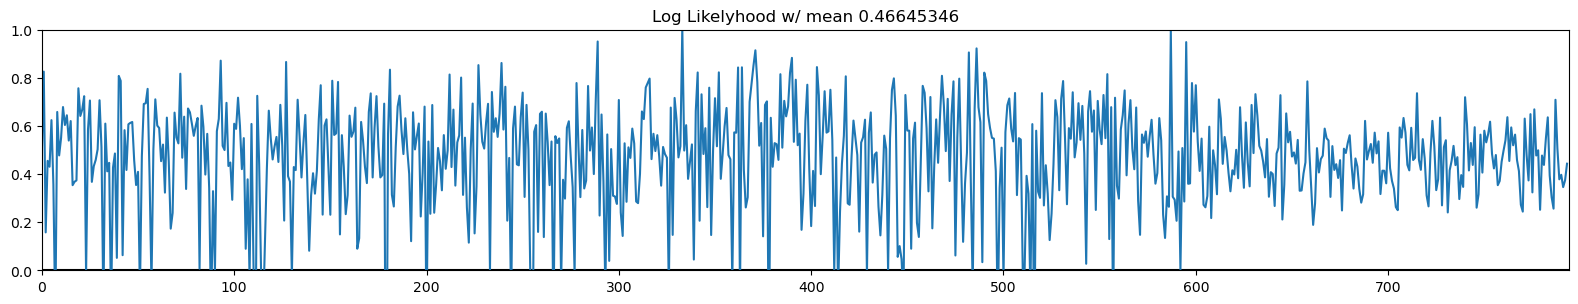

In [17]:
print('Mean LL:', np.mean(LL)) #, 'L4 Exc LL:', np.mean(LL[L4_exc_idx]), 'L4 Inh LL:', np.mean(LL[L4_inh_idx]), 
#      'L23 Exc LL:', np.mean(LL[L23_exc_idx]), 'L23 Inh LL:', np.mean(LL[L23_inh_idx]))
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.xlim([0,NC])
plt.ylim([0,1])
plt.show()

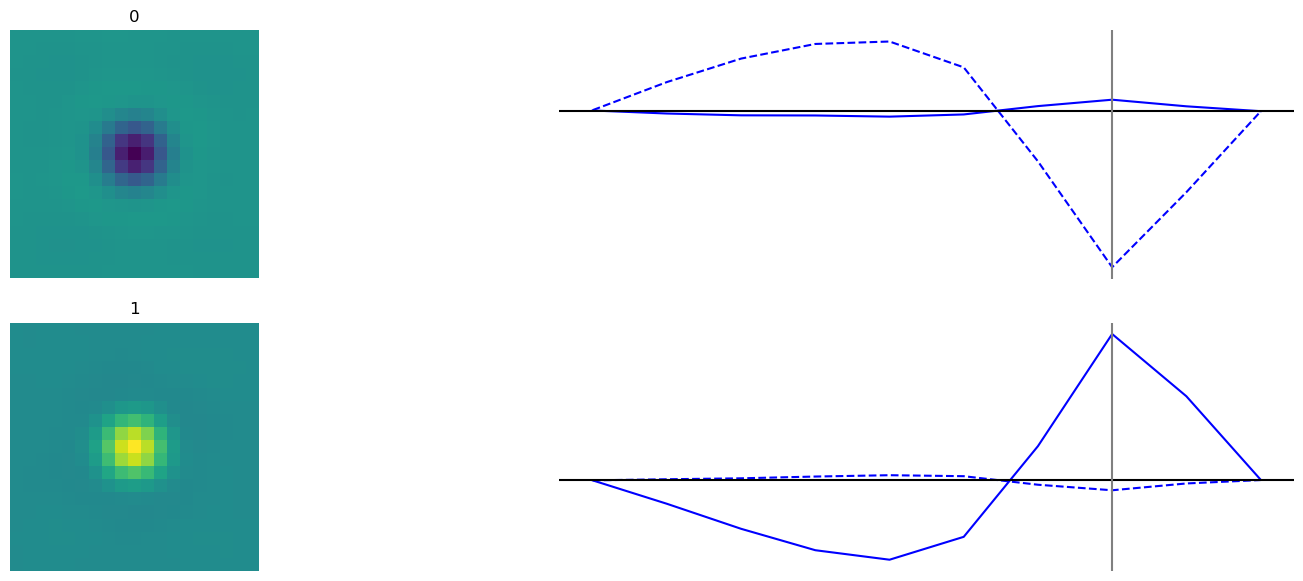

In [18]:
cnn.plot_filters()

In [19]:
filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask_layer1 = deepcopy(cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(cnn.networks[0].layers[2]._ei_mask).detach().cpu().numpy()
print(filters1.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)

(2, 19, 19, 24)
(24,)
(16,)


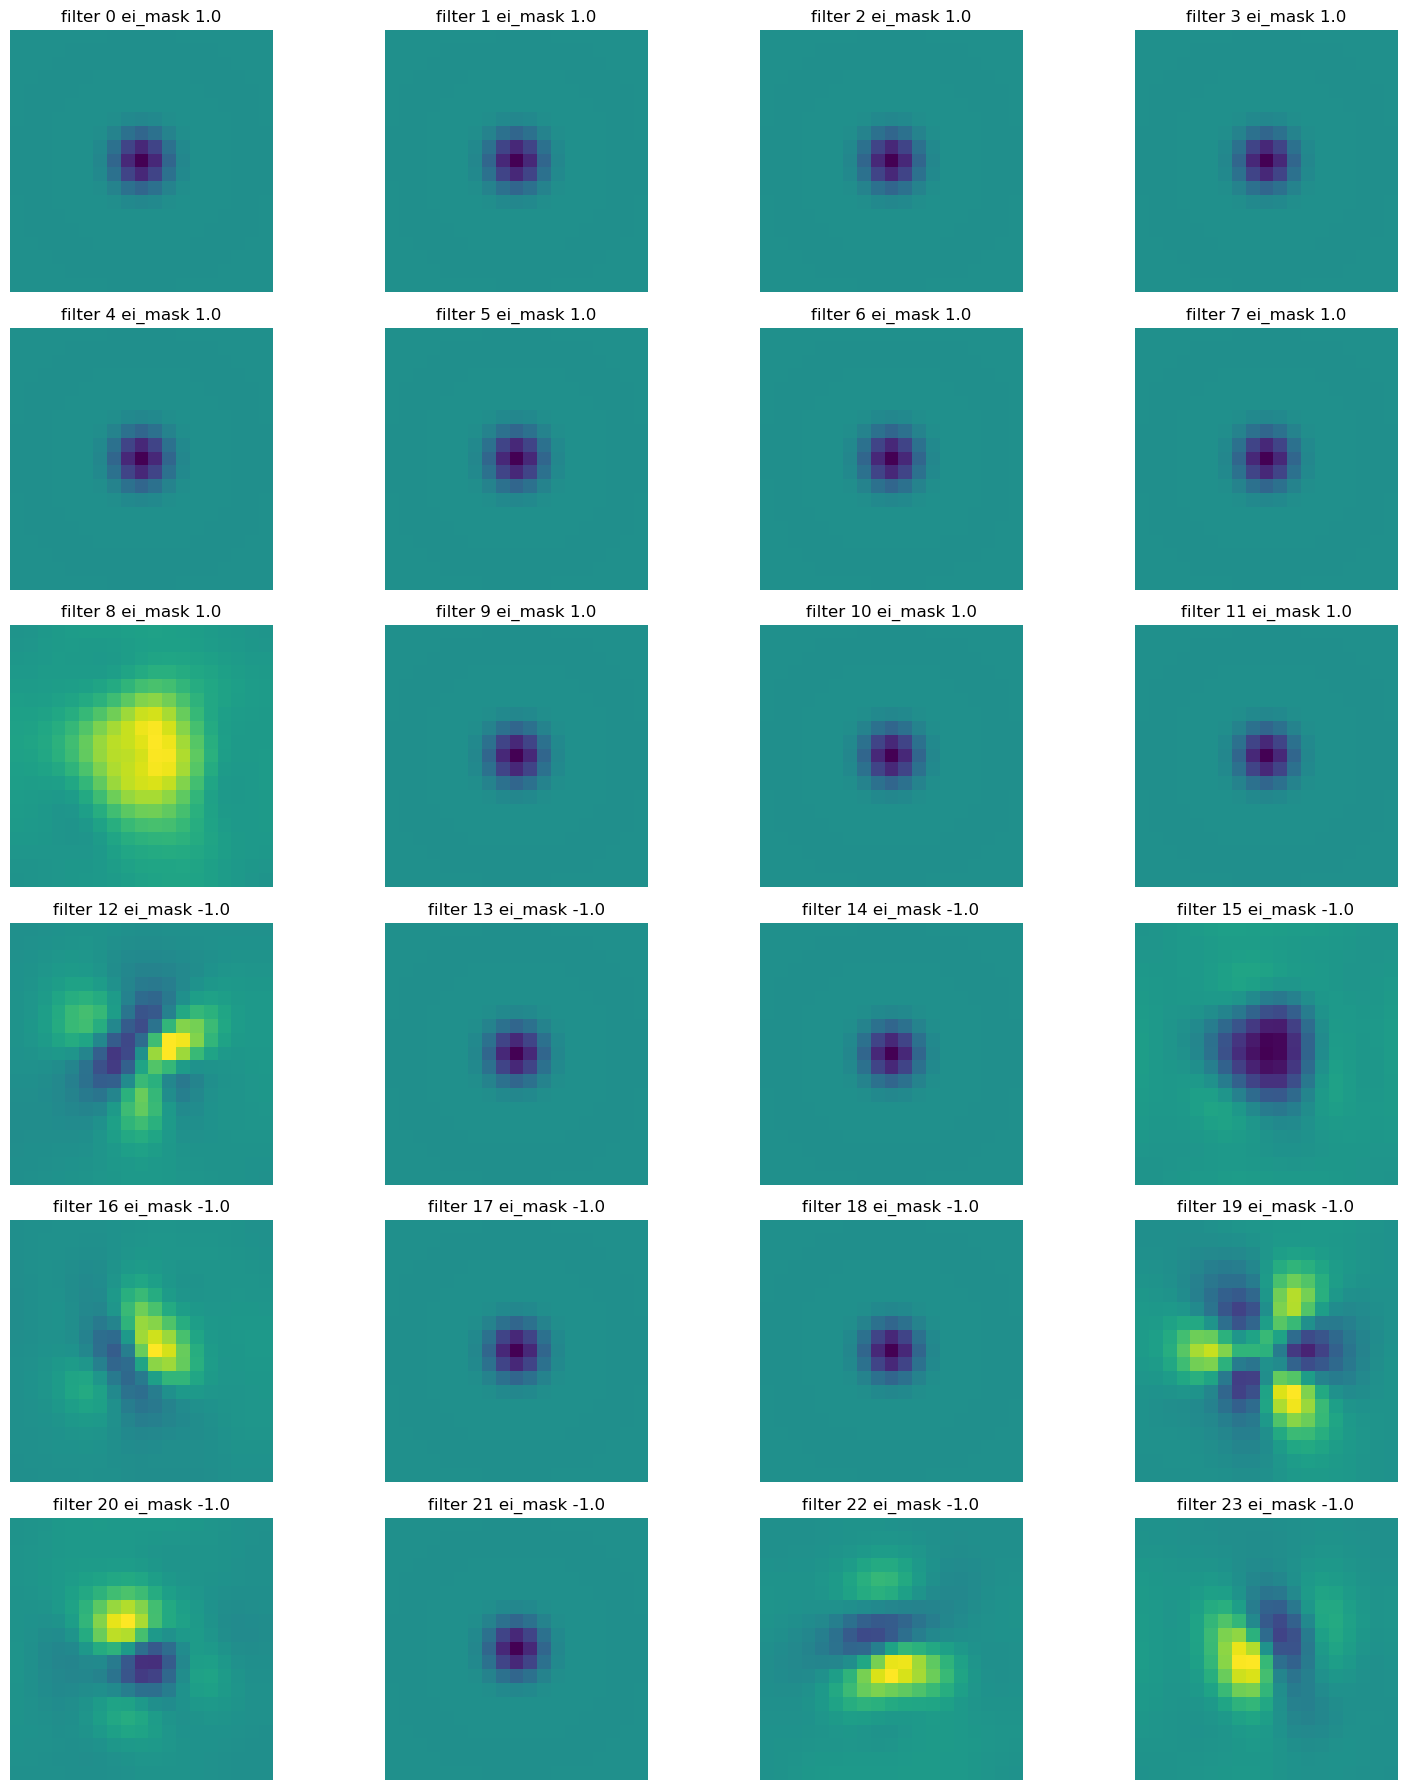

In [22]:
ss(6,4)
for i in range(24):
    plt.subplot(6,4,i+1)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.axis('off')
    plt.title('filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
plt.tight_layout()
plt.show()

In [23]:
# Readout Weights (i.e. Barcodes)
full_ei_mask = np.concatenate((ei_mask_layer1, ei_mask_layer2))
readout_w = cnn.get_weights(ffnet_target=1)
print(readout_w.shape)
print(full_ei_mask.shape)

(40, 794)
(40,)


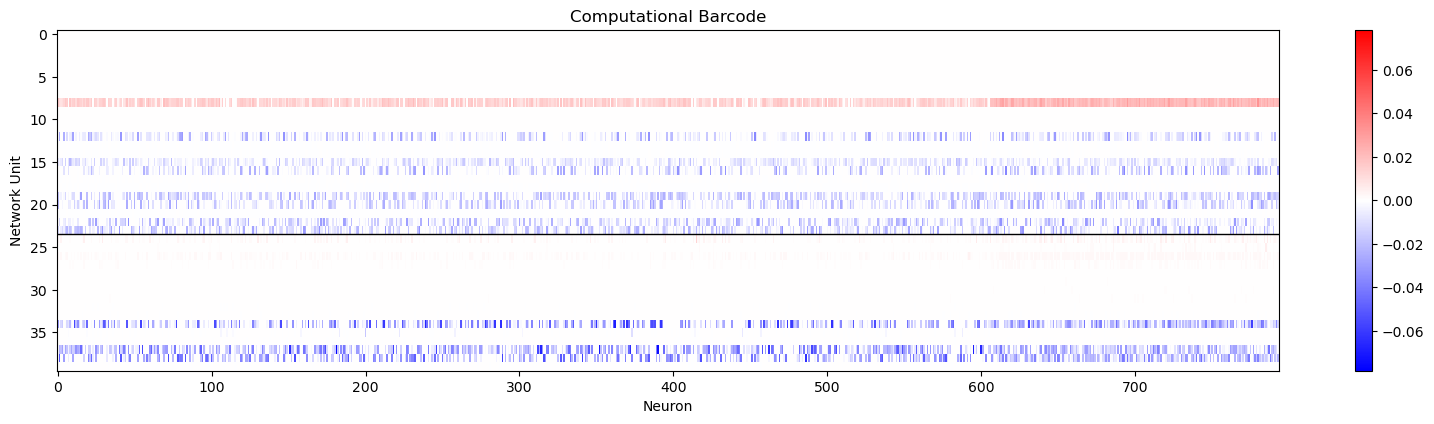

In [24]:
ss(rh=4)
imagesc((readout_w*full_ei_mask.reshape(full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=ei_mask_layer1.shape[0]-0.5, color='black', lw=1)
plt.title('Computational Barcode')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

In [25]:
weight_sum = np.sum(readout_w, axis=1)/np.std(readout_w, axis=1)
print(weight_sum.shape)

(40,)


Text(0.5, 3.722222222222216, 'Network Unit')

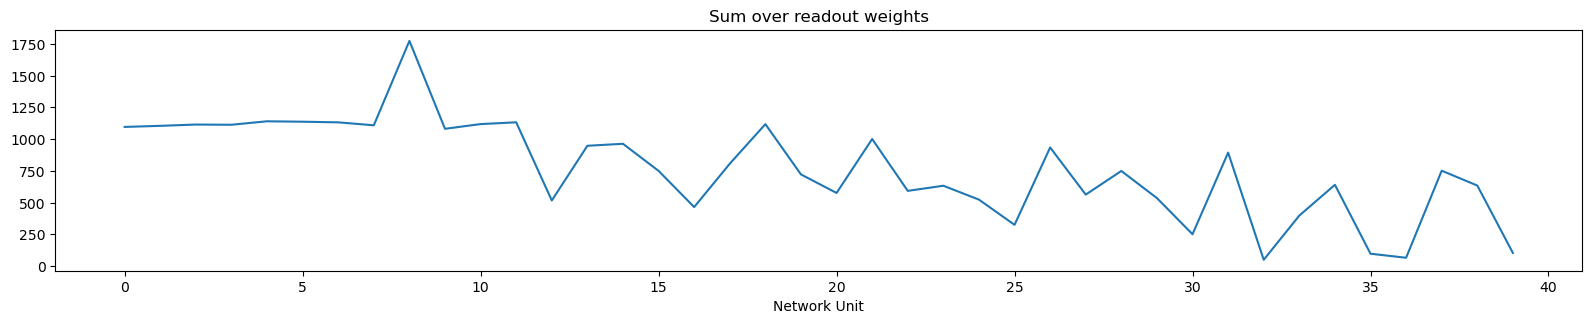

In [26]:
ss()
plt.plot(weight_sum)
plt.title('Sum over readout weights')
plt.xlabel('Network Unit')

In [27]:
filt_count = np.sum(readout_w > 0.001, axis=0)
filt_count_layer1 = np.sum(readout_w[:ei_mask_layer1.shape[0],:] > 0.001, axis=0)
filt_count_layer2 = np.sum(readout_w[ei_mask_layer1.shape[0]:,:] > 0.001, axis=0)
filt_count.shape

(794,)

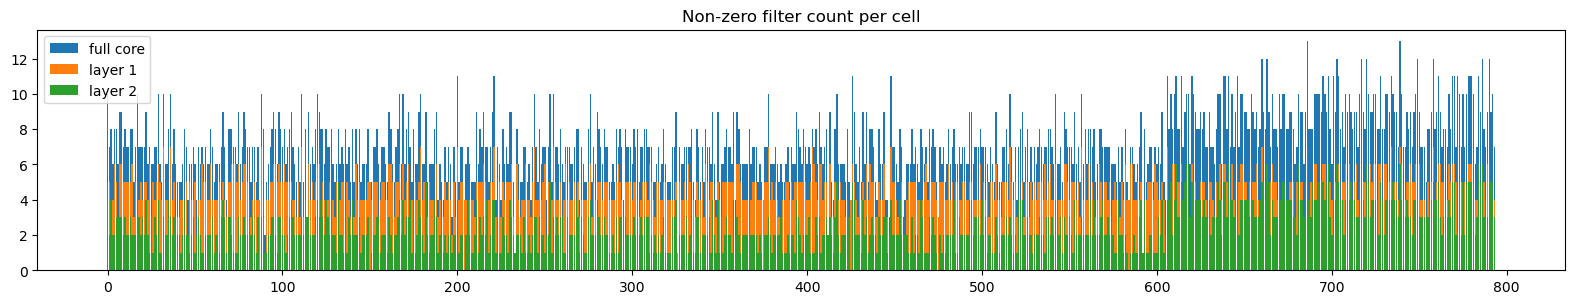

In [28]:
ss()
plt.bar(np.arange(NC),filt_count, label='full core')
plt.bar(np.arange(NC),filt_count_layer1, label='layer 1')
plt.bar(np.arange(NC),filt_count_layer2, label='layer 2')
plt.title('Non-zero filter count per cell')
plt.legend()

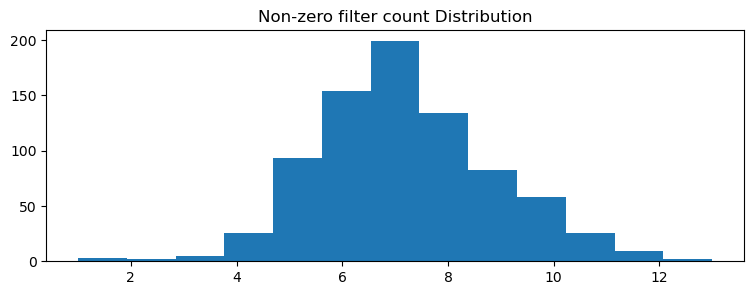

In [29]:
plt.figure(figsize=(9,3))
plt.hist(filt_count ,bins=13)
plt.title('Non-zero filter count Distribution')
plt.show()

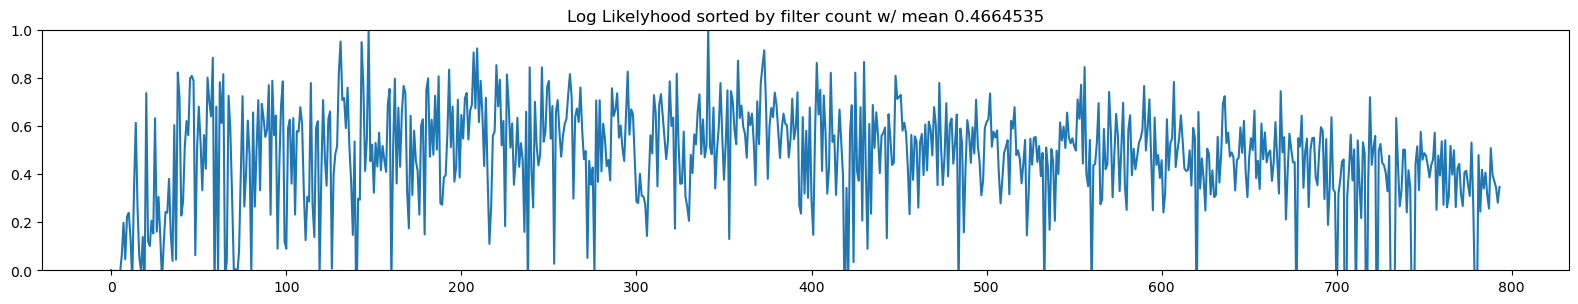

In [30]:
ss()
plt.plot(LL[np.argsort(filt_count)])
plt.title('Log Likelyhood sorted by filter count w/ mean '+str(np.mean(LL[np.argsort(filt_count)])))
plt.ylim([0,1])
plt.show()

In [31]:
filters2 = cnn.get_weights(ffnet_target=0,layer_target=2)
filters2.shape

(24, 5, 5, 2, 16)

In [32]:
weight_dist_layer2 = np.zeros((filters2.shape[-1],filters2.shape[0]))
for i in range(filters2.shape[-1]):
    weight_dist_layer2[i,:] = np.mean(filters2[:,:,:,0,i], axis=(1,2))

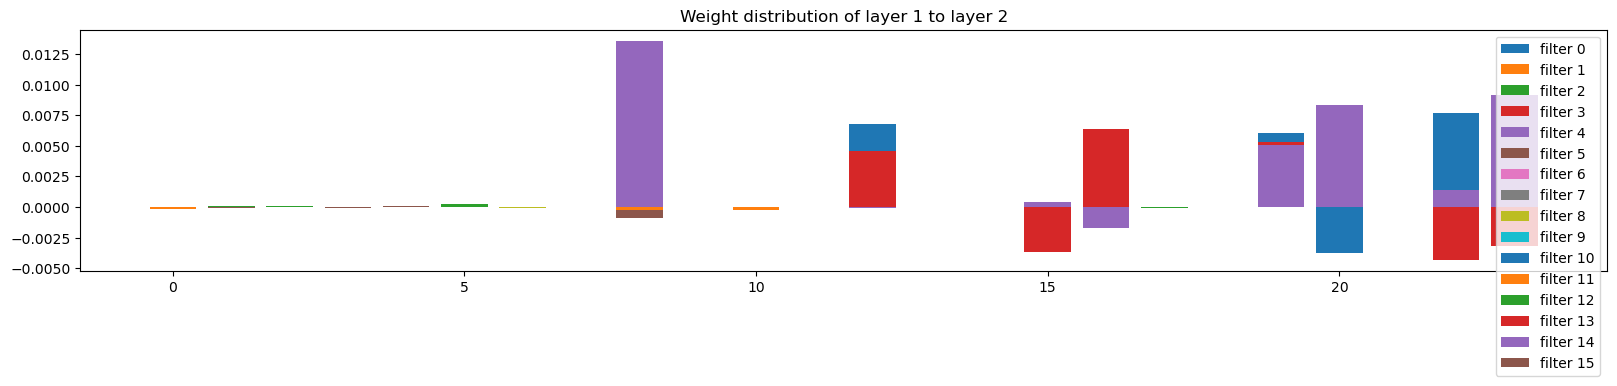

In [33]:
ss()
for i in range(filters2.shape[-1]):
    plt.bar(np.arange(filters2.shape[0]),weight_dist_layer2[i,:], label='filter '+str(i))
    plt.legend()
    plt.title("Weight distribution of layer 1 to layer 2")
    #plt.ylim([-0.02,0.02])

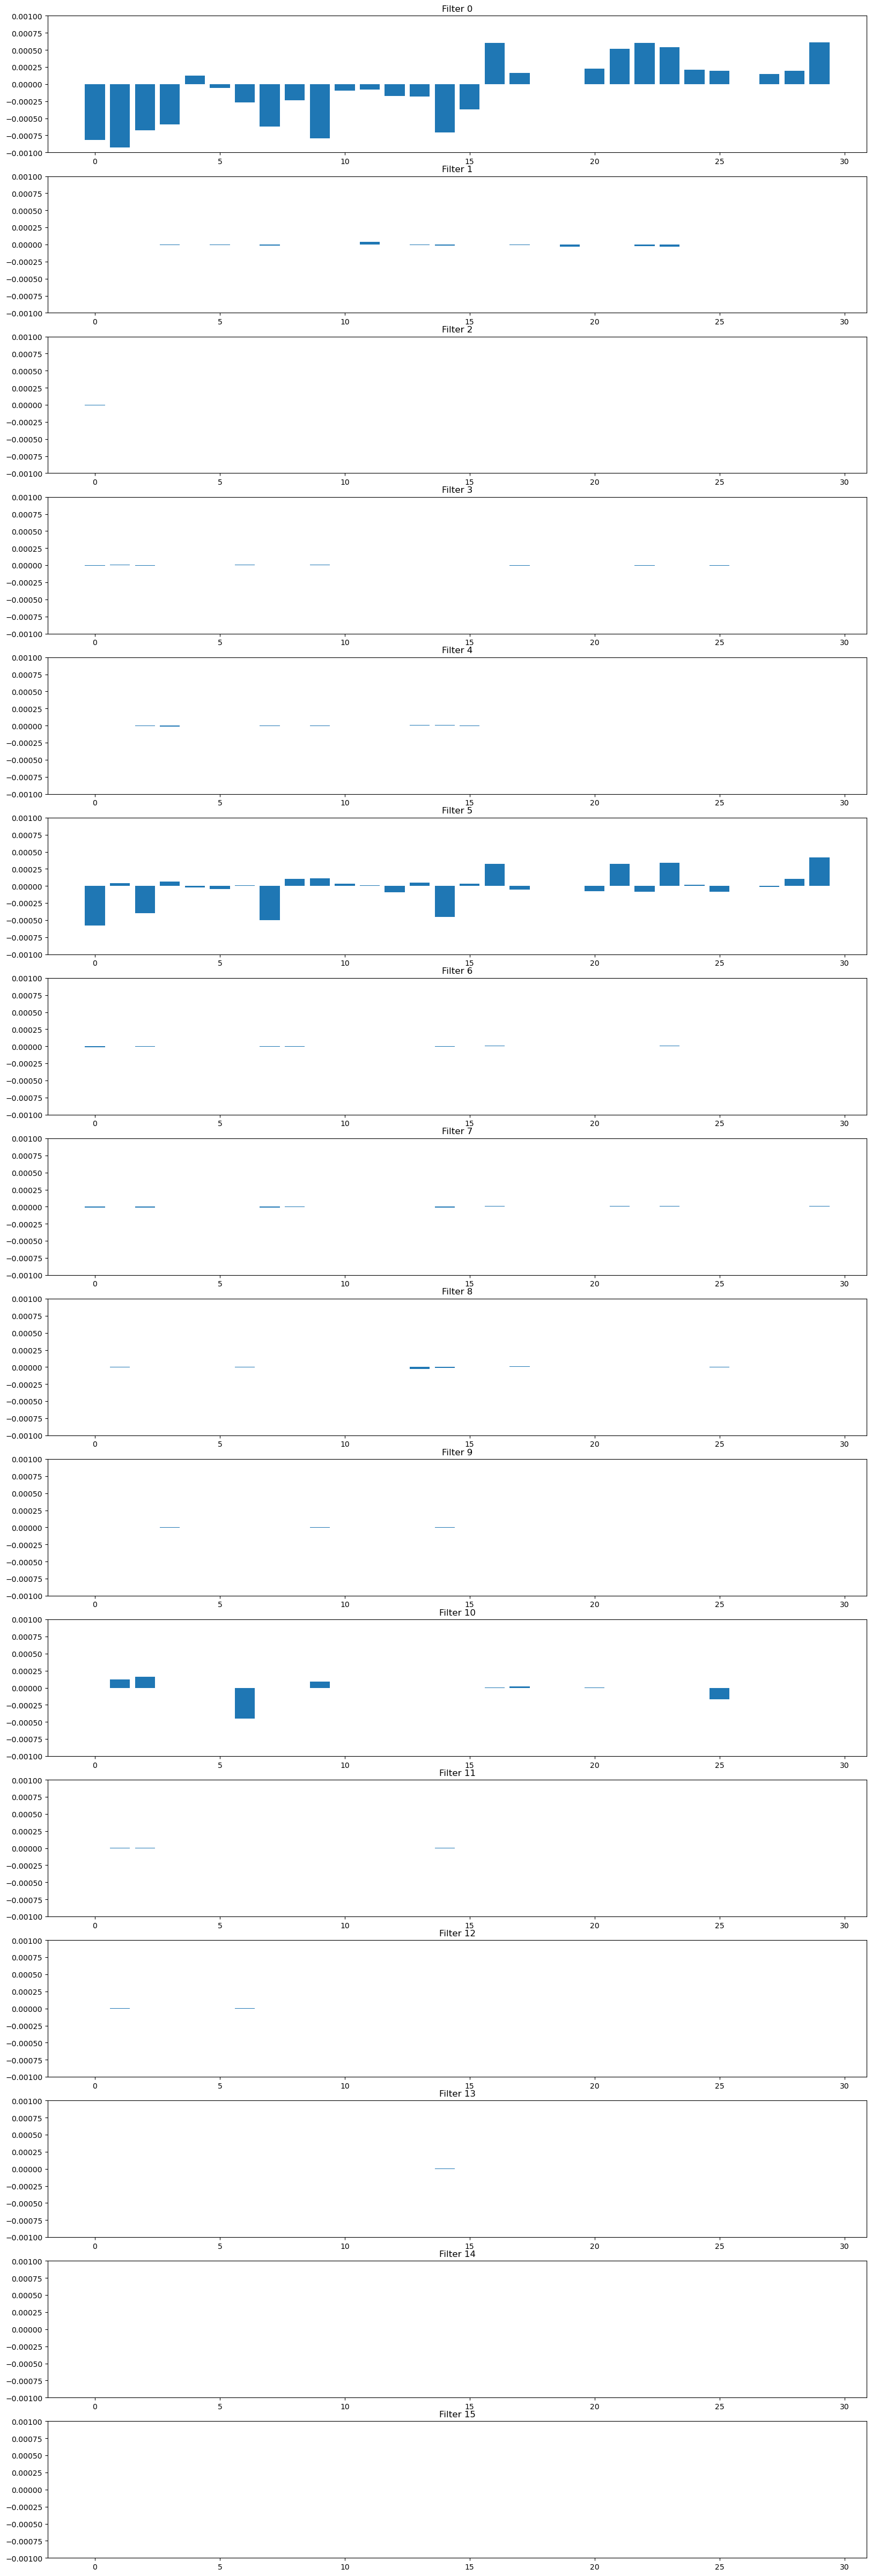

In [33]:
ss(16,1)
for i in range(filters2.shape[-1]):
    plt.subplot(16,1,i+1)
    plt.bar(np.arange(filters2.shape[0]),weight_dist_layer2[i,:])
    plt.ylim([-0.001,0.001])
    plt.title('Filter '+str(i))